In [1]:
import tensorflow as tf
from keras import backend as K
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2']

In [2]:
from pycocotools.coco import COCO
import skimage.io as io
import pylab
import numpy as np
import matplotlib.pyplot as plt

# STEP ONE - Import images and their corresponding text into data points
dataDir='../../../data'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

names = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(names)))

super_cats = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(super_cats)))

data_dict = []
random_cats = ['pizza']#, 'elephant', 'snowboard', 'horse', 'apple']
for r in random_cats:
    catIds = coco.getCatIds(catNms=[r]);
    imgIds = coco.getImgIds(catIds=catIds)
    for i in range(len(imgIds)):
        print('processing %d of %d'%(i, len(imgIds)))
        img = coco.loadImgs(imgIds[i])[0]
        I = io.imread(img['coco_url'])
        annIds = coco_caps.getAnnIds(imgIds=img['id'])
        anns = coco_caps.loadAnns(annIds)
        data_dict.append({'img': I, 'texts': [a['caption'] for a in anns]})

#a = coco_caps.showAnns(anns)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
kitchen vehicle furniture animal person electronic appliance outdoor food indoor accessory sports
processing 0 of 153
processing 1 of 153
processing 2 of 153
processing 3 

In [4]:
import os
import numpy as np
GLOVE_DIR = '../../../data/glove'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [5]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
MAX_SEQUENCE_LENGTH = 16

from skimage.transform import resize

def dodgy_resize(img):
    return resize(img, (128,128))

borked_vocab_pairs = {
    'plae': 'plate',
    'egyption': 'egyptian',
    'selfie': 'photo',
    "pizza's": "pizzas",
    'wiith': 'with',
    'hald': 'half', 
    'topings': 'toppings',
    'pototes': 'potatoes',
    'peporoni': 'pepperoni',
    'individauls': 'individuals',
    "that's": 'that is',
    'restaruant': 'restaurant',
    'thath as': 'that has',
    'casenext': 'case next',
    'pizzaa': 'pizza',
    "family's": "family",
    'peeson': 'person',
    'hefevwsen': 'european',
    'cheesey': 'cheesy'
}

texts = []  # list of text samples
vocab = []
lengths = []
skip = False
examples = []
for d in data_dict:
    for a in d['texts']:
        if len(a.split(' ')) > MAX_SEQUENCE_LENGTH:
            #MAX_SEQUENCE_LENGTH = len(a.split(' '))
            #print('new longest text: ', MAX_SEQUENCE_LENGTH, a)
            skip = True
    if skip:
        skip = False
        continue
        
    for a in d['texts']:
        line = a
        line = line.replace('.','').replace(',', ' ').strip().lower()
        
        match = [k for k in borked_vocab_pairs.keys() if k in line]
        if len(match) > 0:
            print('found borked text')

        for m in match:
            print(m)
            line = line.replace(m, borked_vocab_pairs[m]) # replace the cooked text with the right text
            print(line)
        
        words = [w.strip() for w in line.split(' ') if len(w) > 0]
        line = ' '.join(words)
        
        texts.append(line) # append all of the caption sentences
        embed = []
        #print('words in sentence: ', a.strip().replace('.','').lower().split(' '))
        for w in line.split(' '):
            #try:
            embed.append(embeddings_index[w])
            #except KeyError:
                
            #    embed.append([0]*100)
        #print(len(embed))
        while len(embed) < 16:
            embed.append([0]*100)
        
        #print(len(embed))
        img_rescale = dodgy_resize(d['img'])
        
        examples.append({'img': img_rescale, 'text': np.array(embed)})
        
        lengths.append(len(line.split(' ')))
        
            
        vocab.extend(words)
        

vocab = list(set(vocab))

print('Found %s texts.' % len(texts))

MAX_NB_WORDS = len(vocab)

print(MAX_NB_WORDS, MAX_SEQUENCE_LENGTH)
print(len(vocab))

# buckets = list(set(lengths))
# #print(sorted(buckets))
# np.histogram(lengths, bins=sorted(buckets))
# print(examples[0]['img'].shape)

/mnt/data2/conda/envs/becks/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


found borked text
egyption
a young girl eating pizza dressed as a egyptian
found borked text
pototes
a plate covered with eggs  meat  potatoes and veggies
found borked text
peeson
a person at a table is eating a small pizza
found borked text
casenext
a set of three pizzas in a display case next to desserts
found borked text
cheesey
the  pizza  is cheesy wiith peporoni for the topping
peporoni
the  pizza  is cheesy wiith pepperoni for the topping
wiith
the  pizza  is cheesy with pepperoni for the topping
found borked text
topings
a sliced pizza in a box with different toppings
found borked text
restaruant
a couple of guys cooking in a restaurant kitchen that is open to the restaurant
found borked text
individauls
individuals gathered outside a building and an american flag at half mast
found borked text
thath as
a table that has some pizza and wine on it
found borked text
pizzaa
there are two pizza and two glasses of wine on the table
found borked text
that's
a fork being held over a ve

In [6]:

# trim the vocab down here
labels_index = {}  # dictionary mapping label name to numeric id
embeddings_index_short = []
for i in range(len(vocab)):
    try:
        # make an array matching each word to index and then a dict matching each word to the index
        embeddings_index_short.append(embeddings_index[vocab[i]]) # [{'the': 100x1}, {'one': 100x1 etc}]
        labels_index[i] = vocab[i]
    except KeyError:
        print("couldn't find:", vocab[i])
        match = [t for t in texts if vocab[i] in t]
        print("might be in: ", match)

embeddings_index_short.append([0.0]*100)
labels_index[i+1] = '<PAD>'
print(all(embeddings_index[labels_index[0]] == embeddings_index_short[0]))

True


In [7]:
# get their keras model working first... simple copy/paste job - DONE
# next extend to do joint text and image embedding
import numpy as np
import keras.utils
from keras.layers import Input,Dense, Flatten,Activation
from keras.models import load_model, Model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D, ZeroPadding2D, MaxPooling2D
from keras.layers import LeakyReLU, Reshape, Concatenate, Multiply, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dot, Lambda
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.models import save_model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from IPython import display
import time

K.tensorflow_backend._get_available_gpus()

def generateTheta(L, endim):
    # generate L random samples from S^(dim-1) where S is the d-dim unit sphere
    theta_=np.random.normal(size=(L,endim))
    for l in range(L):
        theta_[l,:]=theta_[l,:]/np.sqrt(np.sum(theta_[l,:] ** 2))
    return theta_

def generateZ(batch, endim):

    z_=2*(np.random.uniform(size=(batchsize,endim))-0.5)
    return z_

def stitchImages(I, axis=0):
    # helps with visualisation
    n,N,M,K = I.shape
    if axis == 0:
        img = np.zeros((N * n,M,K))
        for i in range(n):
            img[i * N:(i+1) * N,:,:]=I[i,:,:,:]
    else:
        img = np.zeros((N,M * n,K))
        for i in range(n):
            img[:,i * M:(i+1) * M,:]=I[i,:,:,:]
    return img

# mnist data import/separate
# (x_train, y_train), (x_test, _) = mnist.load_data()
# x_train = np.expand_dims(x_train.astype('float32')/255., 3)
# plt.imshow(np.squeeze(x_train[0, ...]))
# plt.show()



In [8]:
# MS Coco data separate/labelling
print(len(examples))
x_train = examples[0:600]
x_test = examples[600:]
print(len(x_train), len(x_test))
train_examples = []
test_examples = []
for x in x_train:
    train_examples.append([x['img'], x['text']])

for x in x_test:
    test_examples.append([x['img'], x['text']])
    
SOLO_TEST = False

675
600 75


In [9]:
def image_encoder(im):
    # with a bit of fiddling this image encoder 'converts' a 128x128x3 image into 28x28x1 lol
    x=Conv2D(input_shape=(128,128,3), filters=2, kernel_size=6, padding='valid')(im)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(16, (3, 3), padding='valid')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=AveragePooling2D((2, 2), padding='valid')(x)
    x=Conv2D(32, (3, 3), padding='valid')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(64, (3, 3), padding='valid')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=AveragePooling2D((2, 2), padding='valid')(x)
    x=Conv2D(1, (3, 3), padding='same')(x)
    
    if SOLO_TEST:
        x=Flatten()(x)
        x=Dense(784,activation='relu')(x)
        x=Dense(196)(x)
    return x

img_big = Input((128, 128, 3))
img_enc = image_encoder(img_big)
img_encoder = Model(inputs=[img_big], outputs=[img_enc])
img_encoder.summary()

if SOLO_TEST:
    #img = Input((28, 28, 1)) 
    interdim = 128 # dimension of intermediate var after conv, before embedding

    enddim = 196 # embedding space
    embedd = Input((enddim,))
    depth = 16
    L = 50
    batchsize = 100

    print(embedd.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 123, 2)       218       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 123, 123, 2)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 16)      304       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 121, 121, 16)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 32)        4640      
__________

In [10]:
def text_encoder(t):
    # with a bit of fiddling this image encoder 'converts' a 128x128x3 image into 28x28x1 lol
    x0a=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(2, 100), strides=(2,1), padding='valid')(t)
    x0a=LeakyReLU(alpha=0.2)(x0a)
    x0b=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(2, 100), strides=(2,1), padding='valid')(t)
    x0b=LeakyReLU(alpha=0.2)(x0b)
    x1a=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(3, 100), strides=(3,1),padding='valid')(t)
    x1a=LeakyReLU(alpha=0.2)(x1a)
    x1b=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(3, 100), strides=(3,1),padding='valid')(t)
    x1b=LeakyReLU(alpha=0.2)(x1b)
    x2a=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(5, 100), strides=(5,1),padding='valid')(t)
    x2a=LeakyReLU(alpha=0.2)(x2a)
    x2b=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(5, 100), strides=(5,1),padding='valid')(t)
    x2b=LeakyReLU(alpha=0.2)(x2b)
    x3a=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(7, 100), strides=(7,1),padding='valid')(t)
    x3a=LeakyReLU(alpha=0.2)(x3a)
    x3b=Conv2D(input_shape=(16, 100, 1), filters=1, kernel_size=(7, 100), strides=(7,1),padding='valid')(t)
    x3b=LeakyReLU(alpha=0.2)(x3b)
    x = Concatenate(1)([x0a, x0b, x1a, x1b, x2a, x2b, x3a, x3b])
    x=Flatten()(x)
    x = Dense(784, activation='relu')(x)
    x = Reshape((28,28,1))(x)

    return x

txt = Input((16, 100, 1))
txt_enc = text_encoder(txt)
text_encoder = Model(inputs=[txt], outputs=[txt_enc])
text_encoder.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 8, 1, 1)      201         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 8, 1, 1)      201         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 5, 1, 1)      301         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (

In [11]:
def encode_block(x, d):
    x = Conv2D(d, (3,3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(d, (3,3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = AveragePooling2D((2,2), padding="same")(x)
    return x

def encoder(depth, interdim, img_enc, txt_enc):
#     mult = [1, 2, 4]
#     for i in mult:
#         x = encode_block(x, depth*i)
    
#     x = Flatten()(x)
#     x = Dense(interdim, activation="relu")(x)
#     encoded = Dense(enddim)(x)
#     return encoded
    x = Multiply()([img_enc, txt_enc])
    x=Conv2D(depth*1, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*1, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=AveragePooling2D((2, 2), padding='same')(x)
    x=Conv2D(depth*2, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*2, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=AveragePooling2D((2, 2), padding='same')(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=AveragePooling2D((2, 2), padding='same')(x)
    x=Flatten()(x)
    x=Dense(interdim,activation='relu')(x)
    encoded=Dense(enddim)(x)
    
    return encoded

#img = Input((28, 28, 1)) 
interdim = 128 # dimension of intermediate var after conv, before embedding

enddim = 100 # embedding space
embedd = Input((enddim,))
depth = 16
L = 50
batchsize = 100

# ENCODER
encoded = encoder(depth, interdim, img_enc, txt_enc)
multi_encoder = Model(inputs=[img_big, txt], outputs=[encoded])
multi_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 123, 123, 2)  218         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 123, 123, 2)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 121, 121, 16) 304         leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [12]:
# DECODER BLOCK
def decode_block(d, x):
    x = Conv2D(d, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(d, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2,2))(x)
    return x
    
def decoder(depth, interdim, x):
    x=Dense(interdim)(embedd)
    x=Dense(depth*64,activation='relu')(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Reshape((4,4,4*depth))(x)
    x=UpSampling2D((2, 2))(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=UpSampling2D((2, 2))(x)
    x=Conv2D(depth*4, (3, 3), padding='valid')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=UpSampling2D((2, 2))(x)
    x=Conv2D(depth*2, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*2, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    decoded=Conv2D(1, (3, 3), padding='same',activation='sigmoid')(x)
    return decoded

decoded = decoder(depth, interdim, embedd)
multi_decoder = Model(inputs=[embedd],outputs=[decoded])
multi_decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

In [13]:
def image_decoder(joint_embed):
    depth = 16
    print('jnt_embed', joint_embed.shape)
    if SOLO_TEST:
        print('testing decoder alone')
        x=Dense(1024)(joint_embed)
        print('decoder after dense', x.shape)
        #x=Dense(depth*64,activation='relu')(x)
        x=Reshape((32,32,1))(x)
        print('decoder - reshape', x.shape)
    else:
        # this decoder should take in some joint embedding of text and image (size 28x28x1) and decode to just an image
        x=ZeroPadding2D((2,2))(joint_embed)
    
    x=UpSampling2D((2, 2))(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    print(x.shape)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    x=UpSampling2D((2, 2))(x)
    print(x.shape)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(depth*4, (3, 3), padding='same')(x)
    x=LeakyReLU(alpha=0.2)(x)
    #x=UpSampling2D((2, 2))(x)
    #x=Conv2D(depth*2, (3, 3), padding='same')(x)
    #x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    #x=Conv2D(depth*2, (3, 3), padding='same')(x)
    #x=LeakyReLU(alpha=0.2)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    # x=BatchNormalization(momentum=0.8)(x)
    decoded=Conv2D(3, (3, 3), padding='same',activation='sigmoid')(x)

    return decoded 


print(img_enc.shape)
#d = decoded if not solo_test else img_enc
#img_dec = image_decoder(embedd)
img_dec = image_decoder(decoded)
print(img_dec)
#img_decoder = Model(inputs=[embedd],outputs=[img_dec])
img_decoder = Model(inputs=[embedd],outputs=[img_dec])
img_decoder.summary()


(?, 28, 28, 1)
jnt_embed (?, 28, 28, 1)
(?, 64, 64, 64)
(?, 128, 128, 64)
Tensor("conv2d_31/Sigmoid:0", shape=(?, 128, 128, 3), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              132096    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 64)          36928     

In [14]:

def text_decoder(joint_embed):
    # go from 28x28x1 to 16x100x1 -> predict what each of the 16 words are... only get 16, no more
    # encoder structure goes from 16x100 -> 2x filters of 2, 3, 5, 7 kernel size concatenated, dense layer then reshape
    # reverse would be 28x28x1 in -> reshape to 734x1, do 6x conv2dtranspose with the filters of the 
    # right size and max pool on the way up or something
    x = Flatten()(joint_embed)
    
    #x = Dense(784)(x)
    x = Dense(144)(x)
    x = Reshape((144, 1, 1))(x)
    x = MaxPooling2D((4,1))(x) # need to drop to 36
    
    x0 = Conv2DTranspose(2, (7,100), strides=(1, 1), padding='valid')(x)
    x0 = Conv2D(2, (6, 100), strides=(3, 1), padding='same')(x0)
    x0 = ZeroPadding2D((1,0))(x0) # when in doubt... pad lol
    x1 = Conv2DTranspose(2, (5,100), strides=(2, 1), padding='valid')(x)
    x1 = Conv2D(2, (6, 100), strides=(5, 1), padding='same')(x1)
    x1 = ZeroPadding2D(((0,1),0))(x1) # when in doubt... pad lol
    x2 = Conv2DTranspose(2, (3,100), strides=(3, 1), padding='valid')(x)
    x2 = Conv2D(2, (3, 100), strides=(7, 1), padding='same')(x2)
    x3 = Conv2DTranspose(2, (2,100), strides=(4, 1), padding='valid')(x)
    x3 = Conv2D(2, (2, 100), strides=(9,1), padding='same')(x3)
    
    # last part should be for every word in the 16 words - match to most likely word from embedding
    x = Concatenate(-1)([x0, x1, x2, x3])
    # this last step produces a 16x100x8 block - then a 1D conv is run over each element of the 100x8 channels per word (x16)
    # resulting shape should be 16x100x1
    x = Conv2D(1, (1, 1))(x)
    # then each of the lines should be matched to a word from the embedding based on cosine dist
    x = Reshape((16, 100, 1))(x)
    #print(x.shape)
    #x = Lambda(cosine_dist, output_shape=(16,))(x)
        

    return x

txt_dec = text_decoder(decoded)
txt_decoder = Model(inputs=[embedd],outputs=[txt_dec])
txt_decoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          12928       input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1024)         132096      dense_4[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 4, 4, 64)     0           dense_5[0][0]                    
__________________________________________________________________________________________________
up_samplin

In [17]:
theta = K.variable(generateTheta(L, enddim))
z = K.variable(generateZ(batchsize, enddim))

ae_encoded = multi_encoder([img_big, txt])
#ae = multi_decoder(ae_encoded)
text_out = txt_decoder(ae_encoded)
img_out = img_decoder(ae_encoded)
autoencoder = Model(inputs=[img_big, txt], outputs=[text_out, img_out])
autoencoder.summary()
print(z.shape, theta.shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 16, 100, 1)   0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 100)          272543      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_6 (Model)                 (None, 16, 100, 1)   444002      model_3[3][0]                    
__________

In [24]:
# img_enc_short = image_encoder(img_big)#, solo_test=True)

# img_enc_mdl = Model(inputs=[img_big],outputs=[img_enc_short])
# img_enc_mdl.summary()
# img_embed = Input((28,28,1))
# img_dec_short = image_decoder(img_embed)#, solo_test=True)
# img_dec_mdl = Model(inputs=[img_embed], outputs=[img_dec_short])
# img_dec_mdl.summary()


img_ae_enc = img_encoder(img_big)#, solo_test=True)
img_ae_dec = img_decoder(img_ae_enc)#, solo_test=True)
img_ae = Model(inputs=[img_big], outputs=[img_ae_dec])
img_ae.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
model_7 (Model)              (None, 196)               793535    
_________________________________________________________________
model_8 (Model)              (None, 128, 128, 3)       314883    
Total params: 1,108,418
Trainable params: 1,108,418
Non-trainable params: 0
_________________________________________________________________


In [8]:
l1 = (1.0)*K.mean(K.abs(K.flatten(img_big) - K.flatten(img_ae_dec)))
l2 = (1.0)*K.mean(K.square(K.flatten(img_big) - K.flatten(img_ae_dec)))
theta = K.variable(generateTheta(L, enddim))
batchsize = 20
z = K.variable(generateZ(batchsize, enddim))
# Project encoded samples
print(img_ae_enc.shape)
proj_ae = K.dot(img_ae_enc, K.transpose(theta))
# Project q_z samples
proj_z = K.dot(z, K.transpose(theta))

W2 = (tf.nn.top_k(tf.transpose(proj_ae), k=batchsize).values - tf.nn.top_k(tf.transpose(proj_z), k=batchsize).values)**2
W2_loss = (10.0)*K.mean(W2)
img_ae_loss = l1 + l2 + W2
img_ae.add_loss(img_ae_loss)

img_ae.compile(optimizer='rmsprop', loss='')

loss = []
img_ex = []
for t in train_examples:
    # split the images and text to pass in together, with the same indices
    img_ex.append(t[0])

img_ex = np.array(img_ex)
train_examples = np.array(train_examples)
print('shapes: ', img_ex.shape, train_examples.shape)

for epoch in range(100):
    ind = np.random.permutation(train_examples.shape[0])
    #print('ind', ind)
    for i in range(int(train_examples.shape[0]/batchsize)):
        X_im_tr = img_ex[ind[i*batchsize:(i+1)*batchsize], ...]
        print('X_im_tr', X_im_tr.shape, 'X_tx_tr')#, X_tx_tr.shape)
        #print(X_tx_tr[0])
        theta_ = generateTheta(L, enddim)
        z_ = generateZ(batchsize, enddim)
        #print('z_', z_)
        K.set_value(z, z_)
        K.set_value(theta, theta_)
        #print('set vals...')
        ll = img_ae.train_on_batch(x=X_im_tr, y=None)
        # for some reason the loss is 60x50x20 or 60xLxbatchsize...
        print(ll.shape)
        loss.extend(ll)
        #print('loss', loss[-1])
    plt.plot(np.asarray(loss))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1e-3)

NameError: name 'img_big' is not defined

(75, 128, 128, 3) (75, 16, 100, 1)
(10, 128, 128, 3)


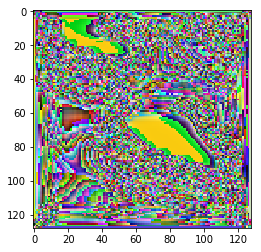

(10, 16, 100, 1)


ValueError: cannot reshape array of size 16000 into shape (100,16,100)

In [32]:
def cosine_dist(words_matrix):
    
    W = K.constant(np.array(embeddings_index_short), shape=(751, 100))
    words_matrix = K.reshape(words_matrix, (None, 16, 100))
    W_norm = K.l2_normalize(W, axis=1)
    words_norm = K.l2_normalize(K.transpose(words_matrix))
    #print(words_norm.shape)
    emb_distances = tf.tensordot(W_norm, words_norm, axes=2)#Dot(axes=1)([W_norm, words_norm])
    token_ids = K.argmax(emb_distances, axis=1)
    return token_ids

img_test_ex = []
txt_test_ex = []
for t in test_examples:
    # split the images and text to pass in together, with the same indices
    img_test_ex.append(t[0])
    txt_test_ex.append(t[1])

img_test_ex = np.array(img_test_ex)
txt_test_ex = np.array(txt_test_ex)
txt_test_ex = np.expand_dims(txt_test_ex, -1)

print(img_test_ex.shape, txt_test_ex.shape)
en=multi_encoder.predict([img_test_ex[:10, ...], txt_test_ex[:10,...]])# Encode the images
dec=img_decoder.predict(en) # Decode the encodings

print(dec.shape)
test_im = dec[9]*255
plt.imshow(test_im)
plt.show()

dec_txt = txt_decoder.predict(en)
print(dec_txt.shape)
out = cosine_dist(np.reshape(dec_txt, (batchsize, 16, 100)))

In [18]:
# Project encoded samples
proj_ae = K.dot(ae_encoded, K.transpose(theta))
# Project q_z samples
proj_z = K.dot(z, K.transpose(theta))

# Sliced Wasserstein distance - sort projections and calculate L2 dist. between
W2 = (tf.nn.top_k(tf.transpose(proj_ae), k=batchsize).values - tf.nn.top_k(tf.transpose(proj_z), k=batchsize).values)**2

print(txt.shape, text_out.shape)
c_e_l_img = (1.0)*K.mean(K.binary_crossentropy(K.flatten(img_big), K.flatten(img_out)))
c_e_l_text = (1.0)*K.mean(K.binary_crossentropy(K.flatten(txt), K.flatten(text_out)))
#combo = Dot(axes=0)([txt_enc,img_enc])
#cross_entropy_loss = (1.0)*K.mean(K.binary_crossentropy(K.flatten(combo), K.flatten(ae)))

# Things to consider - only L1 on direct input/output of AE middle part? L2 on image/text reconstruction parts only?
#L1_loss = (1.0)*K.mean(K.abs(K.flatten(ae_encoded) - K.flatten(ae))) # L1 loss plus Cross Entropy combined
W2_loss = (10.0)*K.mean(W2)

vae_loss = W2_loss + c_e_l_img + c_e_l_text #cross_entropy_loss + L1_loss + 

autoencoder.add_loss(vae_loss)
autoencoder.compile(optimizer='rmsprop', loss='')


(?, 16, 100, 1) (?, 16, 100, 1)


/mnt/data2/conda/envs/becks/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Output "model_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_6" during training.
/mnt/data2/conda/envs/becks/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Output "model_5" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "model_5" during training.


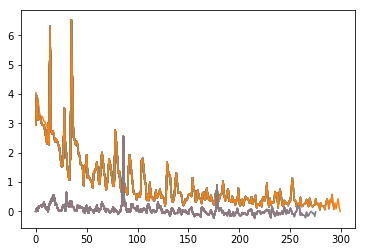

loss -0.141588
loss 0.185749
loss 0.132655
loss 0.0862119


KeyboardInterrupt: 

In [22]:
loss = []
#print(len(x_train[0]['img']))

#print(train_examples[0][0].shape)
img_ex = []
txt_ex = []
for t in train_examples:
    # split the images and text to pass in together, with the same indices
    img_ex.append(t[0]) 
    txt_ex.append(t[1])

img_ex = np.array(img_ex)
txt_ex = np.array(txt_ex)
txt_ex = np.expand_dims(txt_ex, -1)
train_examples = np.array(train_examples)
print('shapes: ', img_ex.shape, txt_ex.shape, train_examples.shape)

for epoch in range(500):
    ind = np.random.permutation(train_examples.shape[0])
    #print('ind', ind)
    for i in range(int(train_examples.shape[0]/batchsize)):
        X_im_tr = img_ex[ind[i*batchsize:(i+1)*batchsize], ...]
        X_tx_tr = txt_ex[ind[i*batchsize:(i+1)*batchsize], ...]
        #print('X_im_tr', X_im_tr.shape, 'X_tx_tr', X_tx_tr.shape)
        #print(X_tx_tr[0])
        theta_ = generateTheta(L, enddim)
        z_ = generateZ(batchsize, enddim)
        #print('z_', z_)
        K.set_value(z, z_)
        K.set_value(theta, theta_)
        #print('set vals...')
        loss.append(autoencoder.train_on_batch(x=[X_im_tr,X_tx_tr], y=None))
        print('loss', loss[-1])
    
    plt.plot(np.asarray(loss))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1e-3)

In [19]:
X_im_tr.shape

(100, 128, 128, 3)

In [21]:
# Test autoencoder
en=encoder.predict(x_train[:2000, ...])# Encode the images
dec=decoder.predict(en) # Decode the encodings



AttributeError: 'function' object has no attribute 'predict'

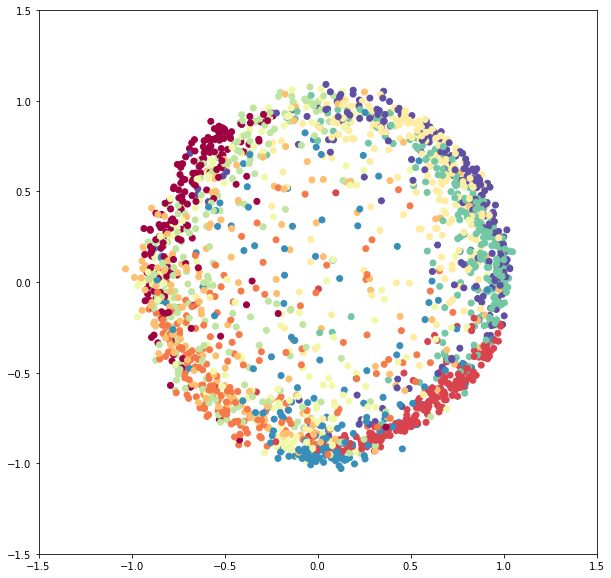

In [11]:
# Distribution of the encoded samples
plt.figure(figsize=(10,10))
plt.scatter(en[:,0],-en[:,1],c=10*y_train[:2000, ...], cmap=plt.cm.Spectral)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()



In [106]:
embeddings_index['wbc']

array([ 0.91328 , -0.69101 ,  1.2958  , -0.64418 ,  0.25526 ,  0.068795,
       -0.4973  ,  0.58153 , -1.2382  ,  0.073927,  1.0314  , -0.39227 ,
        0.13978 , -0.4373  ,  0.52564 ,  0.031997, -0.19936 , -0.057152,
        0.51996 , -1.2727  ,  0.5984  , -0.94248 ,  0.56368 ,  0.62409 ,
        0.42496 ,  0.47312 ,  0.33726 , -1.2589  ,  0.74492 ,  1.1448  ,
       -0.4413  , -0.49335 , -0.27624 ,  0.12414 ,  0.34888 ,  0.96627 ,
       -1.3186  ,  0.6939  , -0.49724 ,  0.70455 ,  0.35445 , -0.38111 ,
        0.79303 , -1.4958  , -0.11855 ,  0.099841, -0.20831 , -0.082838,
       -0.83026 , -0.082735, -0.83842 ,  0.20612 , -0.38835 ,  0.3182  ,
        1.2964  , -0.52529 ,  1.0961  ,  0.56357 , -0.18584 , -0.10215 ,
        0.62196 , -0.53294 ,  0.22695 , -0.12021 ,  0.40608 , -0.90975 ,
       -0.70949 ,  0.73353 , -0.7956  , -0.076525,  0.73368 , -0.20214 ,
       -0.23993 ,  0.80611 , -0.40837 , -0.56891 , -0.96188 , -0.01718 ,
       -1.0373  ,  0.21382 ,  0.15579 , -1.5391  , 